In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy.core.defchararray as npchar
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# set initial properties for data location
res = 40000
data_location = "matrices/"
true_location = "trueTADs/"
armatus_location = "./armatus"
out_location = "yielded/"
noise_values = [4, 8, 12, 16, 20]
sim_values = list(range(1, 6))
TAD_callers = ("lava_modularity", "lava_armatus")

In [3]:
# set range of gammas for methods
armatus_gamma = [i / 2 for i in range(11)]
modularity_gamma = list(range(101))
potts_gamma = list(range(41))
corner_gamma = [1,2]
cutoff_values = [10 ** i for i in range(-5, 3, 1)]
window_values = [res * i for i in list(np.arange(0.5, 5, 0.5))]

In [4]:
# set plotting values
sns.set_palette(sns.color_palette("hls", 12))

In [5]:
# custom functions
vector_str = np.vectorize(str)

def TAD_bins(arr1, arr2):
    vector_str = np.vectorize(str)
    return npchar.add(vector_str(arr1), npchar.add(",", vector_str(arr2)))

def TAD_boundaries(arr1, arr2):
    return np.unique(np.append(arr1, arr2))

def jaccard_index(arr1, arr2):
    intersection = np.isin(arr1, arr2)
    return sum(intersection) / (arr1.shape[0] + arr2.shape[0] - sum(intersection))

def overlap_coef(arr1, arr2):
    intersection = np.isin(arr1, arr2)
    return sum(intersection) / min(arr1.shape[0], arr2.shape[0])

In [6]:
# load true TADs coordinates
true_TADs = pd.DataFrame(index=noise_values, columns=sim_values)
for noise in noise_values:
    for sim in sim_values:
        print(f"\rnoise={noise} sim={sim}", end="")
        true_TADs.loc[noise, sim] = np.loadtxt(f"{true_location}simHiC_TADintervals_coords_noise{noise}_sim{sim}.txt")
print("\nfinished")

noise=20 sim=5
finished


In [7]:
# combine true TADs coordinates into strings
true_TADs_bins = pd.DataFrame(index=noise_values, columns=sim_values)
for noise in noise_values:
    for sim in sim_values:
        true_TADs_bins.loc[noise, sim] = npchar.add(vector_str(true_TADs.loc[noise, sim][:, 0]), npchar.add(",", vector_str(true_TADs.loc[noise, sim][:, 1])))

In [8]:
# make unique true TADs boundaries
true_TADs_boundaries = pd.DataFrame(index=noise_values, columns=sim_values)
for noise in noise_values:
    for sim in sim_values:
        true_TADs_boundaries.loc[noise, sim] = np.unique(np.append(true_TADs.loc[noise, sim][:, 0], true_TADs.loc[noise, sim][:, 1]))

In [9]:
stats = ("TPR TADs", "TPR boundaries", "FDR TADs", "FDR boundaries")

In [10]:
#lava modularity stats for all files
lava_modularity_stats = pd.DataFrame(index=range(len(noise_values) * len(sim_values) * len(modularity_gamma) * len(stats)), columns=list(("value", "stat", "noise", "sim", "gamma", "amount", "size_tads")))
item = 0
for noise in noise_values:
    for sim in sim_values:
        for gamma in modularity_gamma:
                print(f"\r method=lava_modularity noise={noise} sim={sim} gamma={gamma}    ", end="")
                TADs = np.loadtxt(f"{out_location}lava_modularity_noise{noise}_sim{sim}_gamma{gamma}.txt", ndmin=2)
                sizes = np.mean(TADs[:, 1] - TADs[:, 0])
                bins = TAD_bins(TADs[:, 0], TADs[:, 1])
                boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
                lava_modularity_stats.loc[item, "value"] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
                lava_modularity_stats.loc[item, "stat":"amount"] = ["TPR TADs", noise, sim, gamma, TADs.shape[0]]
                lava_modularity_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_modularity_stats.loc[item, "value"] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
                lava_modularity_stats.loc[item, "stat":"amount"] = ["FDR TADs", noise, sim, gamma, TADs.shape[0]]
                lava_modularity_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_modularity_stats.loc[item, "value"] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
                lava_modularity_stats.loc[item, "stat":"amount"] = ["TPR boundaries", noise, sim, gamma, TADs.shape[0]]
                lava_modularity_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_modularity_stats.loc[item, "value"] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]
                lava_modularity_stats.loc[item, "stat":"amount"] = ["FDR boundaries", noise, sim, gamma, TADs.shape[0]]
                lava_modularity_stats.loc[item, "size_tads"] = sizes
                item += 1

 method=lava_modularity noise=20 sim=5 gamma=100    

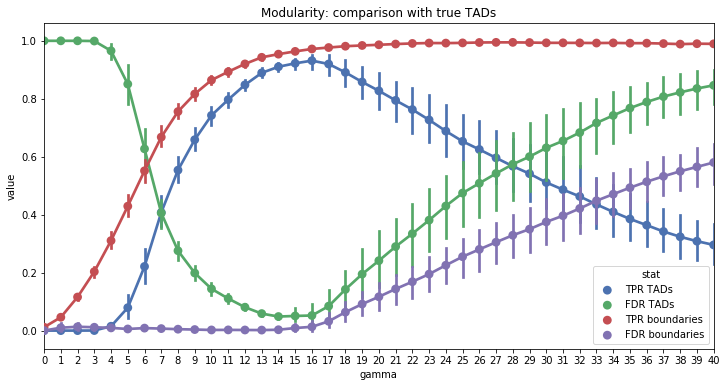

In [16]:
mpl.rcParams['figure.figsize'] = [12, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_modularity_stats, x="gamma", y="value", hue="stat")
plt.xlim(0, 40)
plt.title("Modularity: comparison with true TADs")
plt.savefig("lava_modularity_stats_short.png")

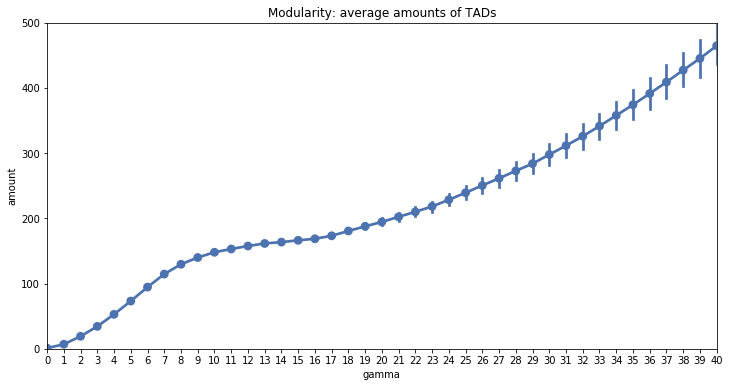

In [20]:
mpl.rcParams['figure.figsize'] = [12, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_modularity_stats, x="gamma", y="amount")
plt.xlim(0, 40)
plt.ylim(0, 500)
plt.title("Modularity: average amounts of TADs")
plt.savefig("lava_modularity_TAD_amount_mean_short.png")

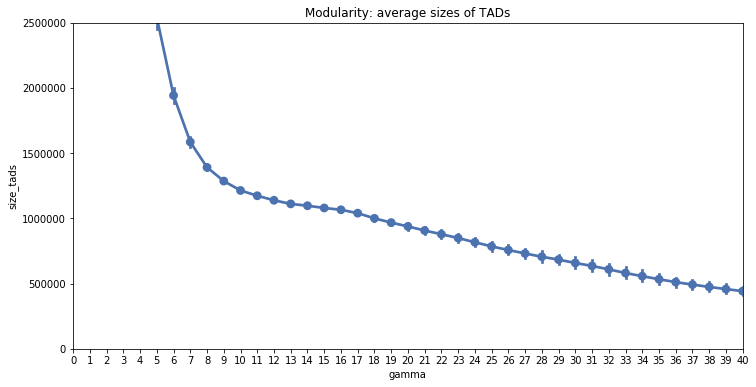

In [19]:
mpl.rcParams['figure.figsize'] = [12, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_modularity_stats, x="gamma", y="size_tads")
plt.ylim(0, 2500000)
plt.xlim(0, 40)
plt.title("Modularity: average sizes of TADs")
plt.savefig("lava_modularity_TAD_size_average_short.png")

The best gamma for modularity score is 15-16

In [15]:
#lava potts stats for the first file
lava_potts_stats = pd.DataFrame(index=range(len(noise_values) * len(sim_values) * len(potts_gamma) * len(stats)), columns=list(("value", "stat", "noise", "sim", "gamma", "amount", "size_tads")))
item = 0
for noise in noise_values:
    for sim in sim_values:
        for gamma in potts_gamma:
                print(f"\r method=lava_potts noise={noise} sim={sim} gamma={gamma}", end="")
                TADs = np.loadtxt(f"{out_location}lava_potts_noise{noise}_sim{sim}_gamma{gamma}.txt", ndmin=2)
                sizes = np.mean(TADs[:, 1] - TADs[:, 0])
                bins = TAD_bins(TADs[:, 0], TADs[:, 1])
                boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
                lava_potts_stats.loc[item, "value"] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
                lava_potts_stats.loc[item, "stat":"amount"] = ["TPR TADs", noise, sim, gamma, TADs.shape[0]]
                lava_potts_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_potts_stats.loc[item, "value"] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
                lava_potts_stats.loc[item, "stat":"amount"] = ["FDR TADs", noise, sim, gamma, TADs.shape[0]]
                lava_potts_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_potts_stats.loc[item, "value"] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
                lava_potts_stats.loc[item, "stat":"amount"] = ["TPR boundaries", noise, sim, gamma, TADs.shape[0]]
                lava_potts_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_potts_stats.loc[item, "value"] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]
                lava_potts_stats.loc[item, "stat":"amount"] = ["FDR boundaries", noise, sim, gamma, TADs.shape[0]]
                lava_potts_stats.loc[item, "size_tads"] = sizes
                item += 1

 method=lava_potts noise=20 sim=5 gamma=40

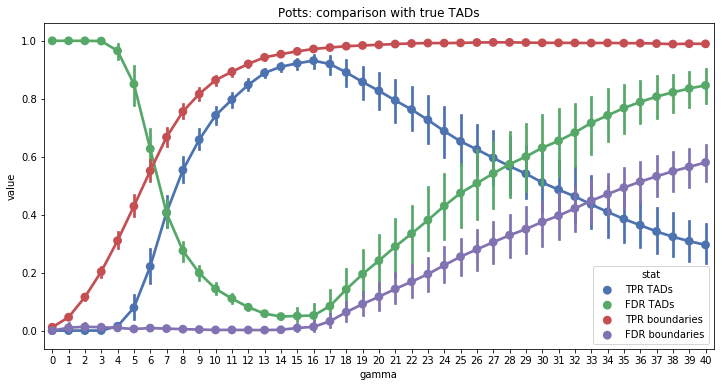

In [41]:
#lava potts stats for all files
mpl.rcParams['figure.figsize'] = [12, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_potts_stats, x="gamma", y="value", hue="stat")
plt.title("Potts: comparison with true TADs")
plt.savefig("lava_potts_stats.png")

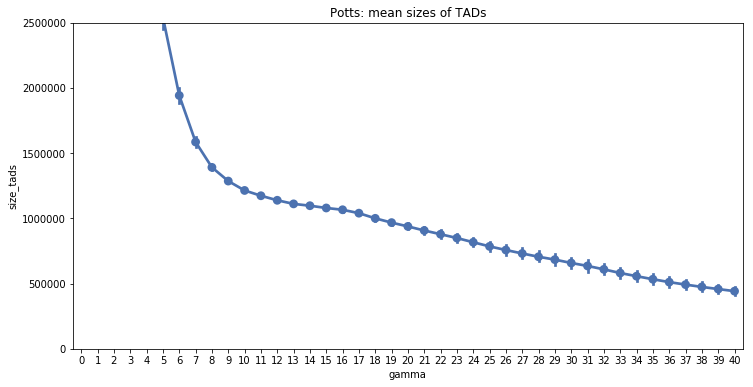

In [21]:
#lava potts median sizes of TADs
mpl.rcParams['figure.figsize'] = [12, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_potts_stats, x="gamma", y="size_tads")
plt.title("Potts: mean sizes of TADs")
plt.ylim(0, 2500000)
plt.savefig("lava_potts_size_tads.png")

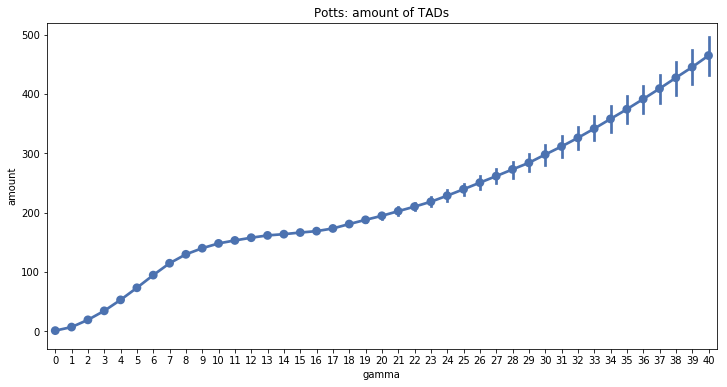

In [25]:
#lava potts amount of TADs
mpl.rcParams['figure.figsize'] = [12, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_potts_stats, x="gamma", y="amount")
plt.title("Potts: amount of TADs")
plt.savefig("lava_potts_amount_tads.png")

For potts the best gamma is 16

In [22]:
#lava variance stats for the first file
lava_variance_stats = pd.DataFrame(index=range(len(range(101)) * len(stats)), columns=list(("value", "stat", "noise", "sim", "gamma", "amount", "size_tads")))
item = 0
for noise in [4]:
    for sim in [1]:
        for gamma in range(101):
                print(f"\r method=lava_variance noise={noise} sim={sim} gamma={gamma}", end="")
                TADs = np.loadtxt(f"{out_location}lava_variance_noise{noise}_sim{sim}_gamma{gamma}.txt", ndmin=2)
                bins = TAD_bins(TADs[:, 0], TADs[:, 1])
                sizes = np.mean(TADs[:, 1] - TADs[:, 0])
                boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
                lava_variance_stats.loc[item, "value"] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
                lava_variance_stats.loc[item, "stat":"amount"] = ["TPR TADs", noise, sim, gamma, TADs.shape[0]]
                lava_variance_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_variance_stats.loc[item, "value"] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
                lava_variance_stats.loc[item, "stat":"amount"] = ["FDR TADs", noise, sim, gamma, TADs.shape[0]]
                lava_variance_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_variance_stats.loc[item, "value"] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
                lava_variance_stats.loc[item, "stat":"amount"] = ["TPR boundaries", noise, sim, gamma, TADs.shape[0]]
                lava_variance_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_variance_stats.loc[item, "value"] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]
                lava_variance_stats.loc[item, "stat":"amount"] = ["FDR boundaries", noise, sim, gamma, TADs.shape[0]]
                lava_variance_stats.loc[item, "size_tads"] = sizes
                item += 1

 method=lava_variance noise=4 sim=1 gamma=100

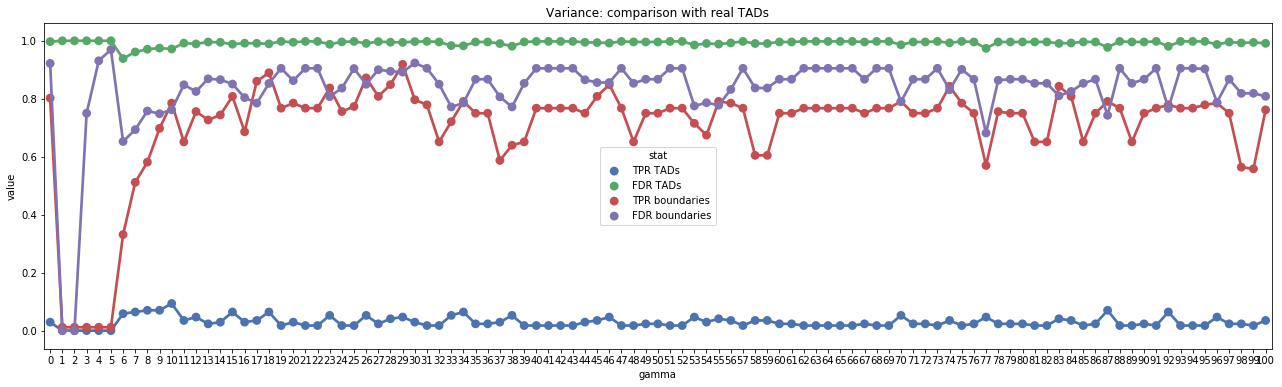

In [39]:
mpl.rcParams['figure.figsize'] = [22, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_variance_stats, x="gamma", y="value", hue="stat")
plt.title("Variance: comparison with real TADs")
plt.savefig("variance_1_stats.png")

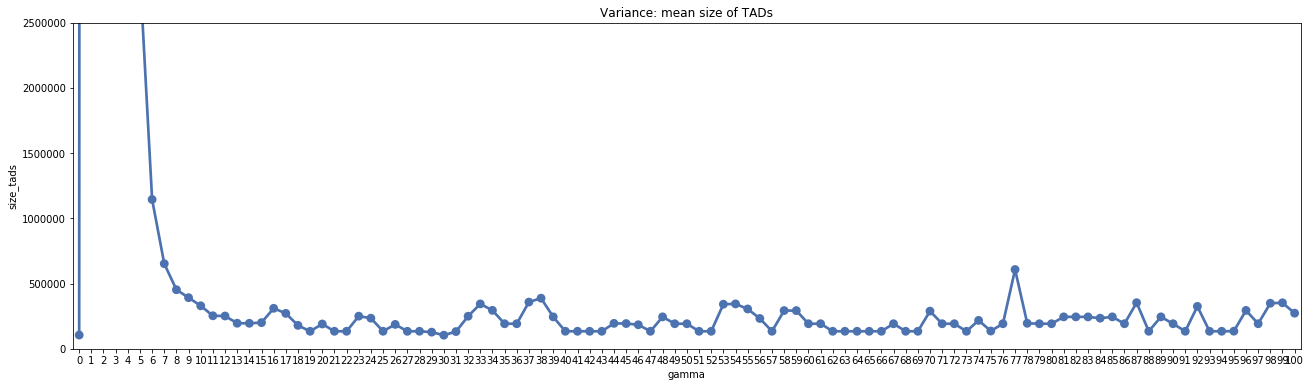

In [23]:
mpl.rcParams['figure.figsize'] = [22, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_variance_stats, x="gamma", y="size_tads")
plt.title("Variance: mean size of TADs")
plt.ylim(0, 2500000)
plt.savefig("variance_1_size_TADs_mean.png")

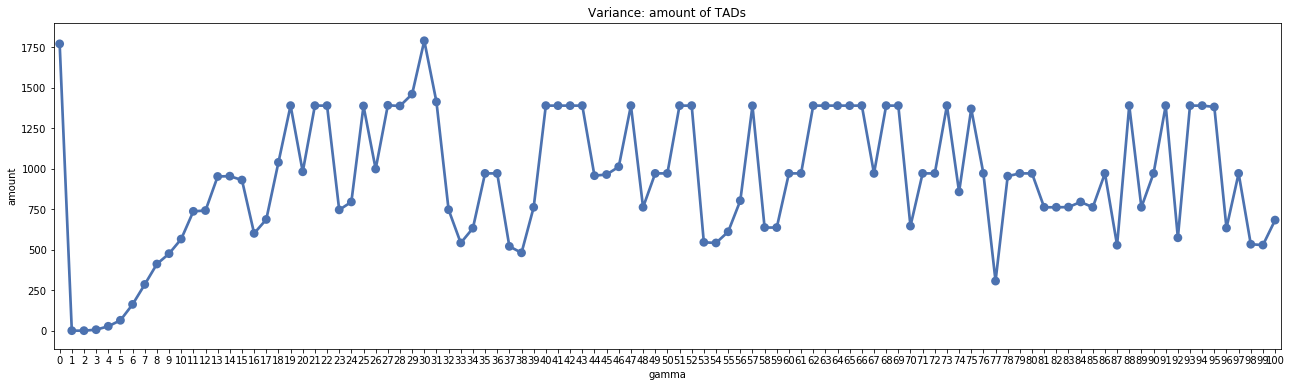

In [31]:
mpl.rcParams['figure.figsize'] = [22, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_variance_stats, x="gamma", y="amount")
plt.title("Variance: amount of TADs")
plt.savefig("variance_1_amount_TADs.png")

In [24]:
#lava corner stats for all files
lava_corner_stats = pd.DataFrame(index=range(len(noise_values) * len(sim_values) * len(corner_gamma) * len(stats)), columns=list(("value", "stat", "noise", "sim", "gamma", "amount", "size_tads")))
item = 0
for noise in noise_values:
    for sim in sim_values:
        for gamma in corner_gamma:
                print(f"\r method=lava_corner noise={noise} sim={sim} gamma={gamma}", end="")
                TADs = np.loadtxt(f"{out_location}lava_corner_noise{noise}_sim{sim}_gamma{gamma}.txt", ndmin=2)
                sizes = np.mean(TADs[:, 1] - TADs[:, 0])
                bins = TAD_bins(TADs[:, 0], TADs[:, 1])
                boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
                lava_corner_stats.loc[item, "value"] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
                lava_corner_stats.loc[item, "stat":"amount"] = ["TPR TADs", noise, sim, gamma, TADs.shape[0]]
                lava_corner_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_corner_stats.loc[item, "value"] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
                lava_corner_stats.loc[item, "stat":"amount"] = ["FDR TADs", noise, sim, gamma, TADs.shape[0]]
                lava_corner_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_corner_stats.loc[item, "value"] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
                lava_corner_stats.loc[item, "stat":"amount"] = ["TPR boundaries", noise, sim, gamma, TADs.shape[0]]
                lava_corner_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_corner_stats.loc[item, "value"] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]
                lava_corner_stats.loc[item, "stat":"amount"] = ["FDR boundaries", noise, sim, gamma, TADs.shape[0]]
                lava_corner_stats.loc[item, "size_tads"] = sizes
                item += 1

 method=lava_corner noise=20 sim=5 gamma=2

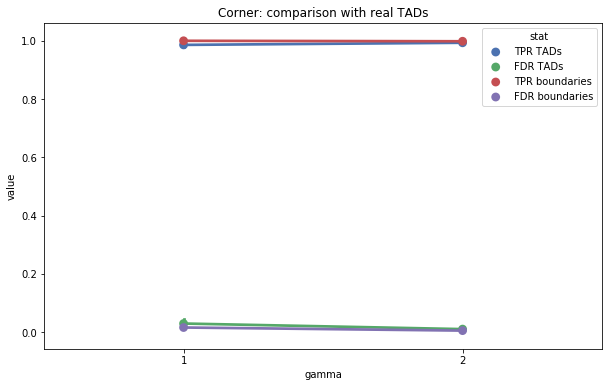

In [37]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_corner_stats, x="gamma", y="value", hue="stat")
plt.title("Corner: comparison with real TADs")
plt.savefig("corner_stats.png")

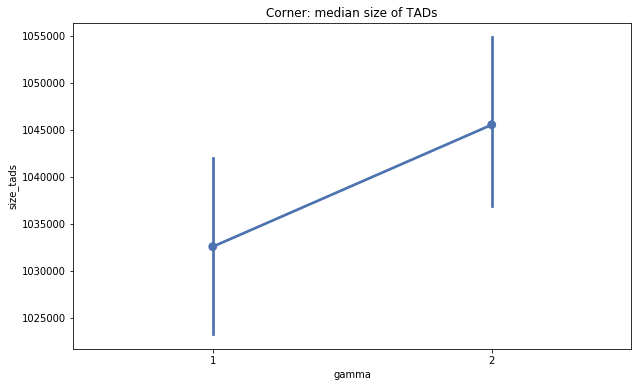

In [25]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_corner_stats, x="gamma", y="size_tads")
plt.title("Corner: median size of TADs")
plt.savefig("corner_size_TADs_mean.png")

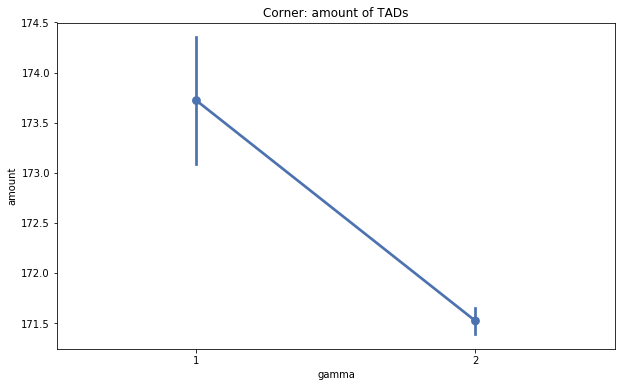

In [35]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_corner_stats, x="gamma", y="amount")
plt.title("Corner: amount of TADs")
plt.savefig("corner_amount_TADs.png")

For corner, gamma=2 is the best.

In [26]:
#ii stats for the first file
cutoff_values = list(range(11))
ii_stats = pd.DataFrame(index=range(len(sim_values) * len(noise_values) * len(window_values) * len(cutoff_values) * len(stats)), columns=list(("value", "stat", "window", "cutoff", "sim", "noise", "amount", "size_tads")))
item = 0
for noise in noise_values:
    for sim in sim_values:
        for window in window_values:
            for cutoff in cutoff_values:
                print(f"\r method=ii noise={noise} sim={sim} window={window} cutoff={cutoff}", end="")
                TADs = np.loadtxt(f"{out_location}ii_noise{noise}_sim{sim}_window{window}_cutoff{cutoff}.txt", ndmin=2)
                if TADs.shape[0] == 0:
                    ii_stats.loc[item, "value"] = 0
                    ii_stats.loc[item, "stat":"size_tads"] = ["TPR TADs", window, cutoff, sim, noise, 0, 0]
                    item += 1
                    ii_stats.loc[item, "value"] = 1
                    ii_stats.loc[item, "stat":"size_tads"] = ["FDR TADs", window, cutoff, sim, noise, 0, 0]
                    item += 1
                    ii_stats.loc[item, "value"] = 0
                    ii_stats.loc[item, "stat":"size_tads"] = ["TPR boundaries", window, cutoff, sim, noise, 0, 0]
                    item += 1
                    ii_stats.loc[item, "value"] = 1
                    ii_stats.loc[item, "stat":"size_tads"] = ["FDR boundaries", window, cutoff, sim, noise, 0, 0]
                    item += 1
                else:
                    bins = TAD_bins(TADs[:, 0], TADs[:, 1])
                    boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
                    sizes = np.mean(TADs[:, 1] - TADs[:, 0]) 
                    ii_stats.loc[item, "value"] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
                    ii_stats.loc[item, "stat":"amount"] = ["TPR TADs", window, cutoff, sim, noise, TADs.shape[0]]
                    ii_stats.loc[item, "size_tads"] = sizes
                    item += 1
                    ii_stats.loc[item, "value"] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
                    ii_stats.loc[item, "stat":"amount"] = ["FDR TADs", window, cutoff, sim, noise, TADs.shape[0]]
                    ii_stats.loc[item, "size_tads"] = sizes
                    item += 1
                    ii_stats.loc[item, "value"] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
                    ii_stats.loc[item, "stat":"amount"] = ["TPR boundaries", window, cutoff, sim, noise, TADs.shape[0]]
                    ii_stats.loc[item, "size_tads"] = sizes
                    item += 1
                    ii_stats.loc[item, "value"] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]
                    ii_stats.loc[item, "stat":"amount"] = ["FDR boundaries", window, cutoff, sim, noise, TADs.shape[0]]
                    ii_stats.loc[item, "size_tads"] = sizes
                    item += 1

 method=ii noise=4 sim=1 window=100000.0 cutoff=2

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim1_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=1 window=120000.0 cutoff=40

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim1_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=1 window=140000.0 cutoff=60

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim1_window140000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=1 window=160000.0 cutoff=1

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim1_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=1 window=180000.0 cutoff=40

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim1_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=2 window=100000.0 cutoff=40

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim2_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=2 window=120000.0 cutoff=70

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim2_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=2 window=140000.0 cutoff=3

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim2_window140000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=2 window=160000.0 cutoff=60

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim2_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=2 window=180000.0 cutoff=2

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim2_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=3 window=100000.0 cutoff=60

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim3_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=3 window=120000.0 cutoff=0

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim3_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=3 window=140000.0 cutoff=40

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim3_window140000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=3 window=160000.0 cutoff=60

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim3_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=3 window=180000.0 cutoff=1

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim3_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=4 window=100000.0 cutoff=30

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim4_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=4 window=120000.0 cutoff=20

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim4_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=4 window=140000.0 cutoff=40

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim4_window140000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=4 window=160000.0 cutoff=50

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim4_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=4 window=180000.0 cutoff=50

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim4_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=5 window=100000.0 cutoff=40

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim5_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=5 window=120000.0 cutoff=50

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim5_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=5 window=140000.0 cutoff=70

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim5_window140000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=5 window=160000.0 cutoff=4

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim5_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=4 sim=5 window=180000.0 cutoff=1

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise4_sim5_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=1 window=60000.0 cutoff=600

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim1_window60000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim1_window60000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=1 window=80000.0 cutoff=3

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim1_window80000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim1_window80000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=1 window=100000.0 cutoff=8

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim1_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim1_window100000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=1 window=120000.0 cutoff=6

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim1_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim1_window120000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=1 window=140000.0 cutoff=4

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim1_window140000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim1_window140000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim1_window140000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=1 window=160000.0 cutoff=90

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim1_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim1_window160000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim1_window160000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=1 window=180000.0 cutoff=6

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim1_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim1_window180000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim1_window180000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=2 window=60000.0 cutoff=200

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim2_window60000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=2 window=80000.0 cutoff=30

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim2_window80000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=2 window=100000.0 cutoff=7

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim2_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim2_window100000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=2 window=120000.0 cutoff=4

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim2_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim2_window120000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=2 window=140000.0 cutoff=2

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim2_window140000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim2_window140000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=2 window=160000.0 cutoff=60

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim2_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim2_window160000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=2 window=180000.0 cutoff=3

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim2_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim2_window180000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=3 window=60000.0 cutoff=300

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim3_window60000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=3 window=80000.0 cutoff=70

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim3_window80000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=3 window=100000.0 cutoff=4

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim3_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim3_window100000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=3 window=120000.0 cutoff=50

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim3_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim3_window120000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=3 window=140000.0 cutoff=0

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim3_window140000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim3_window140000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=3 window=160000.0 cutoff=60

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim3_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim3_window160000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=3 window=180000.0 cutoff=3

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim3_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim3_window180000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=4 window=60000.0 cutoff=400

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim4_window60000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=4 window=80000.0 cutoff=60

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim4_window80000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=4 window=100000.0 cutoff=5

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim4_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim4_window100000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=4 window=120000.0 cutoff=80

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim4_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim4_window120000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=4 window=140000.0 cutoff=5

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim4_window140000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim4_window140000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=4 window=160000.0 cutoff=3

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim4_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim4_window160000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=4 window=180000.0 cutoff=60

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim4_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim4_window180000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=5 window=60000.0 cutoff=400

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim5_window60000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim5_window60000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=5 window=80000.0 cutoff=50

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim5_window80000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim5_window80000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=5 window=100000.0 cutoff=3

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim5_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim5_window100000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=5 window=120000.0 cutoff=00

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim5_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim5_window120000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=5 window=140000.0 cutoff=00

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim5_window140000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim5_window140000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=5 window=160000.0 cutoff=70

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim5_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim5_window160000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=8 sim=5 window=180000.0 cutoff=5

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim5_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise8_sim5_window180000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=1 window=60000.0 cutoff=10

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window60000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window60000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window60000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=1 window=80000.0 cutoff=70

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window80000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window80000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window80000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=1 window=100000.0 cutoff=5

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window100000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window100000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=1 window=120000.0 cutoff=0

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window120000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window120000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=1 window=140000.0 cutoff=80

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window140000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window140000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window140000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=1 window=160000.0 cutoff=7

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window160000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window160000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=1 window=180000.0 cutoff=6

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window180000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window180000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim1_window180000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=2 window=60000.0 cutoff=300

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window60000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window60000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window60000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=2 window=80000.0 cutoff=80

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window80000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window80000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window80000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=2 window=100000.0 cutoff=6

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window100000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window100000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=2 window=120000.0 cutoff=1

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window120000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window120000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=2 window=140000.0 cutoff=80

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window140000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window140000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window140000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window140000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=2 window=160000.0 cutoff=4

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window160000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window160000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window160000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=2 window=180000.0 cutoff=60

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window180000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window180000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim2_window180000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=3 window=60000.0 cutoff=700

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window60000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window60000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=3 window=80000.0 cutoff=4

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window80000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window80000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=3 window=100000.0 cutoff=1

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window100000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window100000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=3 window=120000.0 cutoff=50

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window120000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window120000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=3 window=140000.0 cutoff=4

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window140000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window140000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window140000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window140000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=3 window=160000.0 cutoff=50

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window160000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window160000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window160000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=3 window=180000.0 cutoff=4

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window180000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim3_window180000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=4 window=60000.0 cutoff=600

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window60000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window60000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=4 window=80000.0 cutoff=2

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window80000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window80000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=4 window=100000.0 cutoff=5

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window100000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window100000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=4 window=120000.0 cutoff=80

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window120000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window120000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=4 window=140000.0 cutoff=5

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window140000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window140000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window140000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window140000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=4 window=160000.0 cutoff=70

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window160000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window160000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window160000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=4 window=180000.0 cutoff=4

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window180000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window180000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim4_window180000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=5 window=60000.0 cutoff=700

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim5_window60000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim5_window60000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=5 window=80000.0 cutoff=3

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim5_window80000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim5_window80000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=5 window=100000.0 cutoff=7

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim5_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim5_window100000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim5_window100000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=5 window=120000.0 cutoff=5

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim5_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim5_window120000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim5_window120000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=5 window=140000.0 cutoff=2

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim5_window140000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim5_window140000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim5_window140000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=5 window=160000.0 cutoff=60

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim5_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim5_window160000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim5_window160000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=12 sim=5 window=180000.0 cutoff=4

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim5_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim5_window180000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise12_sim5_window180000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=16 sim=1 window=60000.0 cutoff=900

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window60000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window60000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window60000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window60000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=16 sim=1 window=80000.0 cutoff=6

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window80000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window80000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window80000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window80000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=16 sim=1 window=100000.0 cutoff=6

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window100000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window100000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window100000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_si

 method=ii noise=16 sim=1 window=120000.0 cutoff=5

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window120000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window120000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window120000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_si

 method=ii noise=16 sim=1 window=140000.0 cutoff=1

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window140000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window140000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window140000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window140000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_si

 method=ii noise=16 sim=1 window=160000.0 cutoff=90

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window160000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window160000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window160000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_si

 method=ii noise=16 sim=1 window=180000.0 cutoff=8

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window180000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window180000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim1_window180000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_si

 method=ii noise=16 sim=2 window=60000.0 cutoff=900

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window60000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window60000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window60000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window60000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=16 sim=2 window=80000.0 cutoff=9

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window80000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window80000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window80000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window80000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=16 sim=2 window=100000.0 cutoff=9

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window100000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window100000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window100000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_si

 method=ii noise=16 sim=2 window=120000.0 cutoff=8

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window120000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window120000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window120000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_si

 method=ii noise=16 sim=2 window=140000.0 cutoff=7

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window140000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window140000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window140000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window140000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_si

 method=ii noise=16 sim=2 window=160000.0 cutoff=6

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window160000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window160000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window160000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_si

 method=ii noise=16 sim=2 window=180000.0 cutoff=5

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window180000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window180000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window180000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim2_window180000.0_cutoff4.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=16 sim=3 window=60000.0 cutoff=100

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window60000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window60000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window60000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window60000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=16 sim=3 window=80000.0 cutoff=10

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window80000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window80000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window80000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window80000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=16 sim=3 window=100000.0 cutoff=8

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window100000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window100000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window100000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_si

 method=ii noise=16 sim=3 window=120000.0 cutoff=8

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window120000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window120000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window120000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_si

 method=ii noise=16 sim=3 window=140000.0 cutoff=7

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window140000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window140000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window140000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window140000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_si

 method=ii noise=16 sim=3 window=160000.0 cutoff=6

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window160000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window160000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window160000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_si

 method=ii noise=16 sim=3 window=180000.0 cutoff=6

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window180000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window180000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim3_window180000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_si

 method=ii noise=16 sim=4 window=60000.0 cutoff=700

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window60000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window60000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window60000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window60000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=16 sim=4 window=80000.0 cutoff=5

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window80000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window80000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window80000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window80000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=16 sim=4 window=100000.0 cutoff=3

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window100000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window100000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window100000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=16 sim=4 window=140000.0 cutoff=00

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window120000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window120000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window120000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_si

 method=ii noise=16 sim=4 window=140000.0 cutoff=9

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window140000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window140000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window140000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window140000.0_cutoff4.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=16 sim=4 window=160000.0 cutoff=9

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window160000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window160000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window160000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_si

 method=ii noise=16 sim=4 window=180000.0 cutoff=7

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window180000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window180000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim4_window180000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_si

 method=ii noise=16 sim=5 window=60000.0 cutoff=700

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window60000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window60000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window60000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window60000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=16 sim=5 window=80000.0 cutoff=4

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window80000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window80000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window80000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window80000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=16 sim=5 window=100000.0 cutoff=2

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window100000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window100000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window100000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=16 sim=5 window=120000.0 cutoff=90

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window120000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window120000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window120000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=16 sim=5 window=140000.0 cutoff=7

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window140000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window140000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window140000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window140000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=16 sim=5 window=160000.0 cutoff=4

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window160000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window160000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window160000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=16 sim=5 window=180000.0 cutoff=2

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window180000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window180000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_sim5_window180000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise16_si

 method=ii noise=20 sim=1 window=20000.0 cutoff=710

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window20000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window20000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=20 sim=1 window=40000.0 cutoff=4

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window40000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window40000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=20 sim=1 window=60000.0 cutoff=1

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window60000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window60000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window60000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window60000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_w

 method=ii noise=20 sim=1 window=100000.0 cutoff=1

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window80000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window80000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window80000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window80000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_w

 method=ii noise=20 sim=1 window=100000.0 cutoff=10

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window100000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window100000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window100000.0_cutoff4.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=20 sim=1 window=120000.0 cutoff=10

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window120000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window120000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window120000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_si

 method=ii noise=20 sim=1 window=140000.0 cutoff=9

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window140000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window140000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window140000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window140000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_si

 method=ii noise=20 sim=1 window=160000.0 cutoff=10

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window160000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window160000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window160000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_si

 method=ii noise=20 sim=1 window=180000.0 cutoff=10

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window180000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window180000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window180000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim1_window180000.0_cutoff4.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_si

 method=ii noise=20 sim=2 window=60000.0 cutoff=40

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window60000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window60000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window60000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window60000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_w

 method=ii noise=20 sim=2 window=80000.0 cutoff=0

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window80000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window80000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window80000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window80000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_w

 method=ii noise=20 sim=2 window=100000.0 cutoff=3

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window100000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window100000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window100000.0_cutoff4.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window100000.0_cutoff5.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=20 sim=2 window=120000.0 cutoff=0

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window120000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window120000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window120000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_si

 method=ii noise=20 sim=2 window=140000.0 cutoff=2

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window140000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window140000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window140000.0_cutoff4.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window140000.0_cutoff5.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=20 sim=2 window=160000.0 cutoff=10

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window160000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window160000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window160000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_si

 method=ii noise=20 sim=2 window=180000.0 cutoff=9

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window180000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window180000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim2_window180000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_si

 method=ii noise=20 sim=3 window=60000.0 cutoff=400

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window60000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window60000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window60000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window60000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_w

 method=ii noise=20 sim=3 window=80000.0 cutoff=1

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window80000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window80000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window80000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window80000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_w

 method=ii noise=20 sim=3 window=100000.0 cutoff=3

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window100000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window100000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window100000.0_cutoff4.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window100000.0_cutoff5.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_si

 method=ii noise=20 sim=3 window=120000.0 cutoff=5

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window120000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window120000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window120000.0_cutoff4.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window120000.0_cutoff5.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_si

 method=ii noise=20 sim=3 window=140000.0 cutoff=8

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window140000.0_cutoff5.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window140000.0_cutoff6.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window140000.0_cutoff7.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_si

 method=ii noise=20 sim=3 window=160000.0 cutoff=9

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window160000.0_cutoff7.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window180000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window180000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_si

 method=ii noise=20 sim=4 window=20000.0 cutoff=710

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window20000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window20000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window20000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=20 sim=4 window=40000.0 cutoff=5

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window40000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window40000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window40000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=20 sim=4 window=60000.0 cutoff=4

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window60000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window60000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window60000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window60000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_w

 method=ii noise=20 sim=4 window=80000.0 cutoff=3

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window80000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window80000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window80000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window80000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_w

 method=ii noise=20 sim=4 window=100000.0 cutoff=3

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window100000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window100000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window100000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_si

 method=ii noise=20 sim=4 window=120000.0 cutoff=3

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window120000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window120000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window120000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_si

 method=ii noise=20 sim=4 window=140000.0 cutoff=5

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window140000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window140000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window140000.0_cutoff4.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window140000.0_cutoff5.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_si

 method=ii noise=20 sim=4 window=160000.0 cutoff=4

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window160000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window160000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window160000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window160000.0_cutoff4.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_si

 method=ii noise=20 sim=4 window=180000.0 cutoff=5

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window180000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window180000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window180000.0_cutoff4.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim4_window180000.0_cutoff5.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_si

 method=ii noise=20 sim=5 window=40000.0 cutoff=800

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window40000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=20 sim=5 window=60000.0 cutoff=7

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window60000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window60000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window60000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window60000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_w

 method=ii noise=20 sim=5 window=80000.0 cutoff=7

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window80000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window80000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window80000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window80000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_w

 method=ii noise=20 sim=5 window=100000.0 cutoff=7

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window100000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window100000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window100000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window100000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_si

 method=ii noise=20 sim=5 window=120000.0 cutoff=7

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window120000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window120000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window120000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window120000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_si

 method=ii noise=20 sim=5 window=140000.0 cutoff=7

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window140000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window140000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window140000.0_cutoff4.txt"
  # Remove the CWD from sys.path while we load stuff.


 method=ii noise=20 sim=5 window=160000.0 cutoff=5

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window160000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window160000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window160000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window160000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_si

 method=ii noise=20 sim=5 window=180000.0 cutoff=5

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window180000.0_cutoff0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window180000.0_cutoff1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window180000.0_cutoff2.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim5_window180000.0_cutoff3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_si

 method=ii noise=20 sim=5 window=180000.0 cutoff=10

In [27]:
ii_stats["value"] = np.array(ii_stats["value"], dtype=float)
ii_stats["amount"] = np.array(ii_stats["amount"], dtype=float)
ii_stats["size_tads"] = np.array(ii_stats["size_tads"], dtype=float)

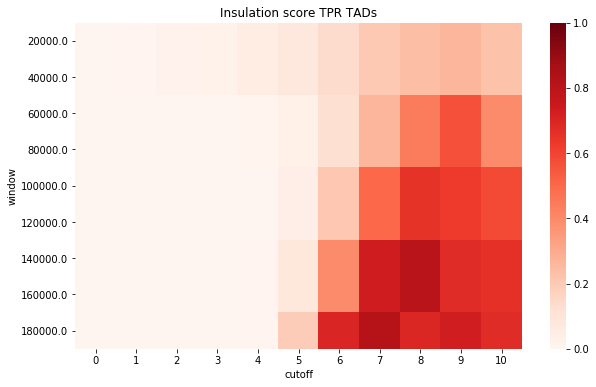

In [116]:
mpl.rcParams['figure.figsize'] = [10, 6]
ii_stats_TPR_bins = ii_stats[ii_stats.stat == "TPR TADs"].pivot_table(index=["window"], columns=["cutoff"], values="value", aggfunc=np.median)
sns.heatmap(ii_stats_TPR_bins, cmap="Reds", center=0.5, vmax=1)
plt.title("Insulation score TPR TADs")
plt.savefig("ii_TPR_TADs.png")

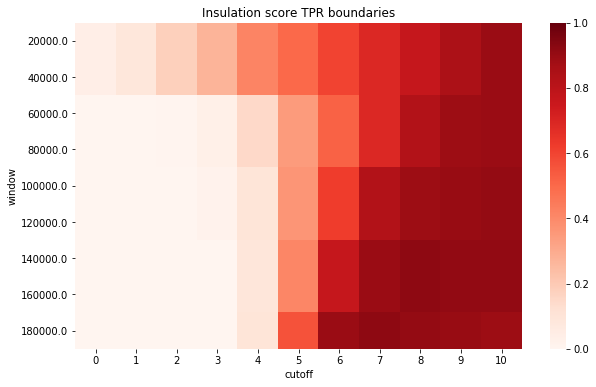

In [117]:
mpl.rcParams['figure.figsize'] = [10, 6]
ii_stats_TPR_boundaries = ii_stats[ii_stats.stat == "TPR boundaries"].pivot_table(index=["window"], columns=["cutoff"], values="value", aggfunc=np.median)
sns.heatmap(ii_stats_TPR_boundaries, cmap="Reds", center=0.5, vmax=1)
plt.title("Insulation score TPR boundaries")
plt.savefig("ii_TPR_boundaries.png")

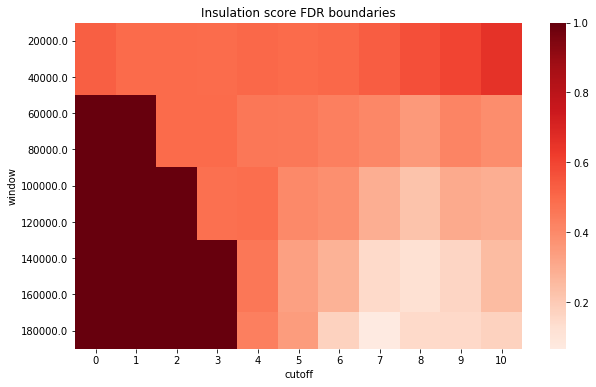

In [118]:
mpl.rcParams['figure.figsize'] = [10, 6]
ii_stats_FDR_boundaries = ii_stats[ii_stats.stat == "FDR boundaries"].pivot_table(index=["window"], columns=["cutoff"], values="value", aggfunc=np.median)
sns.heatmap(ii_stats_FDR_boundaries, cmap="Reds", center=0.5, vmax=1)
plt.title("Insulation score FDR boundaries")
plt.savefig("ii_FDR_boundaries.png")

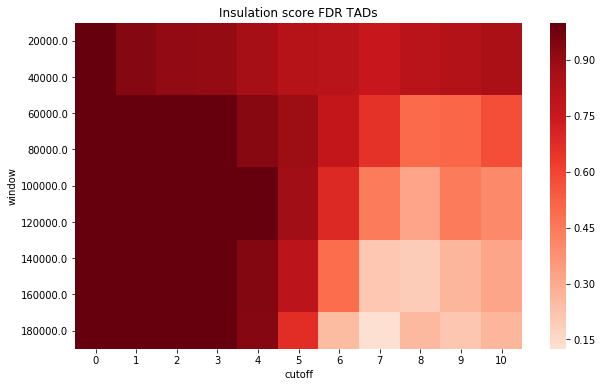

In [119]:
mpl.rcParams['figure.figsize'] = [10, 6]
ii_stats_FDR_bins = ii_stats[ii_stats.stat == "FDR TADs"].pivot_table(index=["window"], columns=["cutoff"], values="value", aggfunc=np.median)
sns.heatmap(ii_stats_FDR_bins, cmap="Reds", center=0.5, vmax=1)
plt.title("Insulation score FDR TADs")
plt.savefig("ii_FDR_TADs.png")

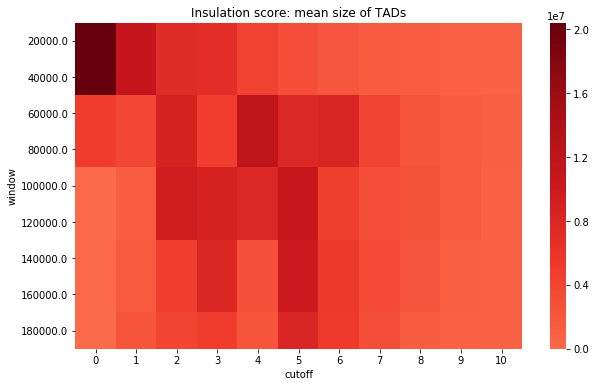

In [35]:
mpl.rcParams['figure.figsize'] = [10, 6]
ii_stats_sizes = ii_stats.pivot_table(index=["window"], columns=["cutoff"], values="size_tads", aggfunc=np.mean)
sns.heatmap(ii_stats_sizes, cmap="Reds", center=0.5)
plt.title("Insulation score: mean size of TADs")
plt.savefig("ii_size_TADs_mean.png")

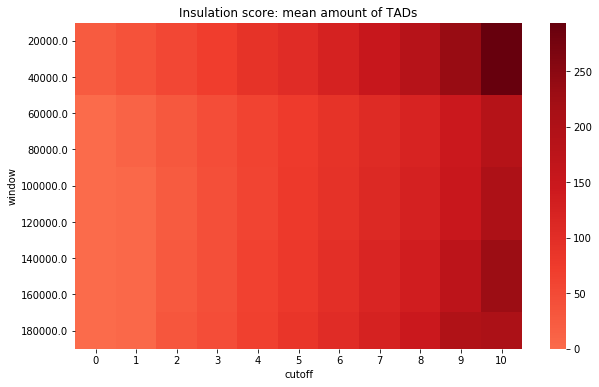

In [30]:
mpl.rcParams['figure.figsize'] = [10, 6]
ii_stats_amount = ii_stats.pivot_table(index=["window"], columns=["cutoff"], values="amount", aggfunc=np.mean)
sns.heatmap(ii_stats_amount, cmap="Reds", center=0.5)
plt.title("Insulation score: mean amount of TADs")
plt.savefig("ii_amount_TADs_mean.png")

Insulation score: cutoff = 6-10, window = 3*binsize - 4*binsize

In [31]:
#di stats for the first file
cutoff_values = list(range(5, 16))
window_values = [i * res for i in range(2, 5)]
di_stats = pd.DataFrame(index=range(len(noise_values) * len(sim_values) * len(window_values) * len(cutoff_values) * len(stats)), columns=list(("value", "stat", "window", "cutoff", "sim", "noise", "amount", "size_tads")))
item = 0
for noise in noise_values:
    for sim in sim_values:
        for window in window_values:
            for cutoff in cutoff_values:
                print(f"\r method=di noise={noise} sim={sim} window={window} cutoff={cutoff}", end="")
                TADs = np.loadtxt(f"{out_location}di_noise{noise}_sim{sim}_window{window}_cutoff{cutoff}.txt", ndmin=2)
                if TADs.shape[0] == 0:
                    di_stats.loc[item, "value"] = 0
                    di_stats.loc[item, "stat":"size_tads"] = ["TPR TADs", window, cutoff, sim, noise, 0, 0]
                    item += 1
                    di_stats.loc[item, "value"] = 1
                    di_stats.loc[item, "stat":"size_tads"] = ["FDR TADs", window, cutoff, sim, noise]
                    item += 1
                    di_stats.loc[item, "value"] = 0
                    di_stats.loc[item, "stat":"size_tads"] = ["TPR boundaries", window, cutoff, sim, noise]
                    item += 1
                    di_stats.loc[item, "value"] = 1
                    di_stats.loc[item, "stat":"size_tads"] = ["FDR boundaries", window, cutoff, sim, noise]
                    item += 1
                else:
                    bins = TAD_bins(TADs[:, 0], TADs[:, 1])
                    boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
                    sizes = np.mean(TADs[:, 1] - TADs[:, 0])
                    di_stats.loc[item, "value"] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
                    di_stats.loc[item, "stat":"amount"] = ["TPR TADs", window, cutoff, sim, noise, TADs.shape[0]]
                    di_stats.loc[item, "size_tads"] = sizes
                    item += 1
                    di_stats.loc[item, "value"] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
                    di_stats.loc[item, "stat":"amount"] = ["FDR TADs", window, cutoff, sim, noise, TADs.shape[0]]
                    di_stats.loc[item, "size_tads"] = sizes
                    item += 1
                    di_stats.loc[item, "value"] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
                    di_stats.loc[item, "stat":"amount"] = ["TPR boundaries", window, cutoff, sim, noise, TADs.shape[0]]
                    di_stats.loc[item, "size_tads"] = sizes
                    item += 1
                    di_stats.loc[item, "value"] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]
                    di_stats.loc[item, "stat":"amount"] = ["FDR boundaries", window, cutoff, sim, noise, TADs.shape[0]]
                    di_stats.loc[item, "size_tads"] = sizes
                    item += 1

 method=di noise=20 sim=5 window=160000 cutoff=15

In [32]:
di_stats["value"] = np.array(di_stats["value"], dtype=float)
di_stats["amount"] = np.array(di_stats["amount"], dtype=float)
di_stats["size_tads"] = np.array(di_stats["size_tads"], dtype=float)

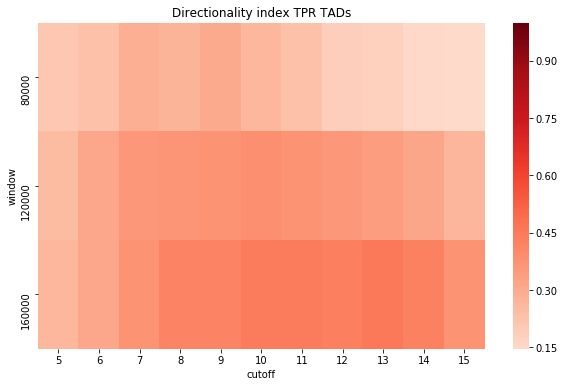

In [21]:
mpl.rcParams['figure.figsize'] = [10, 6]
di_stats_TPR_bins = di_stats[di_stats.stat == "TPR TADs"].pivot_table(index=["window"], columns=["cutoff"], values="value", aggfunc=np.median)
sns.heatmap(di_stats_TPR_bins, cmap="Reds", center=0.5, vmax=1)
plt.title("Directionality index TPR TADs")
plt.savefig("di_TPR_TADs_4.png")

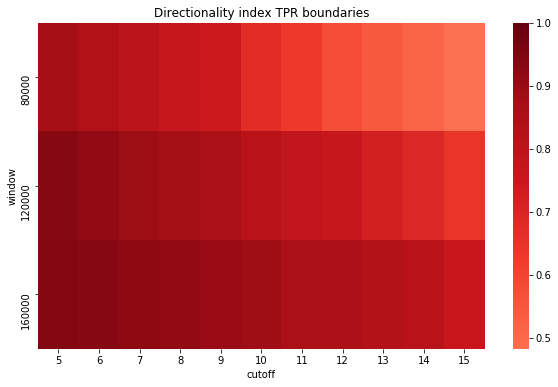

In [22]:
mpl.rcParams['figure.figsize'] = [10, 6]
di_stats_TPR_boundaries = di_stats[di_stats.stat == "TPR boundaries"].pivot_table(index=["window"], columns=["cutoff"], values="value", aggfunc=np.median)
sns.heatmap(di_stats_TPR_boundaries, cmap="Reds", center=0.5, vmax=1)
plt.title("Directionality index TPR boundaries")
plt.savefig("di_TPR_boundaries_4.png")

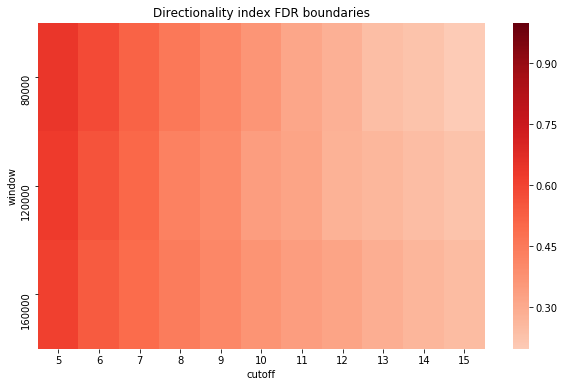

In [23]:
mpl.rcParams['figure.figsize'] = [10, 6]
di_stats_FDR_boundaries = di_stats[di_stats.stat == "FDR boundaries"].pivot_table(index=["window"], columns=["cutoff"], values="value", aggfunc=np.median)
sns.heatmap(di_stats_FDR_boundaries, cmap="Reds", center=0.5, vmax=1)
plt.title("Directionality index FDR boundaries")
plt.savefig("di_FDR_boundaries_4.png")

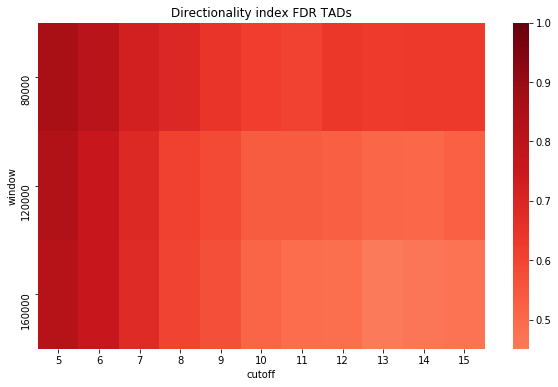

In [24]:
mpl.rcParams['figure.figsize'] = [10, 6]
di_stats_FDR_bins = di_stats[di_stats.stat == "FDR TADs"].pivot_table(index=["window"], columns=["cutoff"], values="value", aggfunc=np.median)
sns.heatmap(di_stats_FDR_bins, cmap="Reds", center=0.5, vmax=1)
plt.title("Directionality index FDR TADs")
plt.savefig("di_FDR_TADs_4.png")

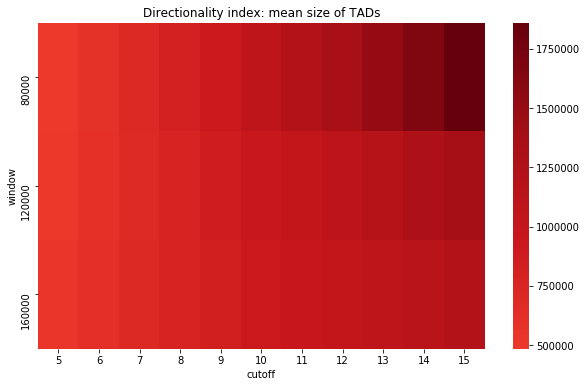

In [33]:
mpl.rcParams['figure.figsize'] = [10, 6]
di_stats_sizes = di_stats.pivot_table(index=["window"], columns=["cutoff"], values="size_tads", aggfunc=np.mean)
sns.heatmap(di_stats_sizes, cmap="Reds", center=0.5)
plt.title("Directionality index: mean size of TADs")
plt.savefig("di_size_TADs_mean.png")

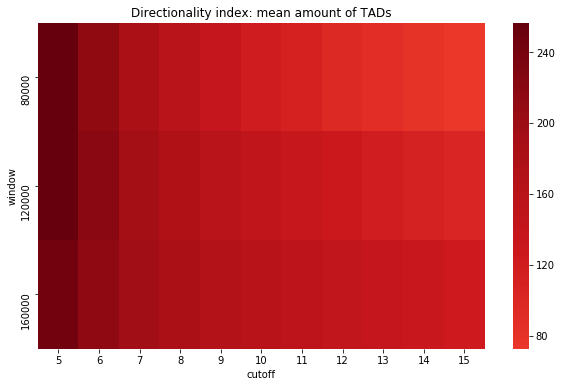

In [34]:
mpl.rcParams['figure.figsize'] = [10, 6]
di_stats_amount = di_stats.pivot_table(index=["window"], columns=["cutoff"], values="amount", aggfunc=np.mean)
sns.heatmap(di_stats_amount, cmap="Reds", center=0.5)
plt.title("Directionality index: mean amount of TADs")
plt.savefig("di_amount_TADs.png")

Based on all simulation, best cutoff= 13 - 15, windowsize= 3 * binsize - 4 * binsize

In [36]:
#lava armatus stats for the all files
armatus_gamma = [i / 10 for i in range(-5, 6)]
lava_armatus_stats = pd.DataFrame(index=range(len(noise_values) * len(sim_values) * len(armatus_gamma) * len(stats)), columns=list(("value", "stat", "noise", "sim", "gamma", "amount", "size_tads")))
item = 0
for noise in noise_values:
    for sim in sim_values:
        for gamma in armatus_gamma:
                print(f"\r method=lava_armatus noise={noise} sim={sim} gamma={gamma}", end="")
                TADs = np.loadtxt(f"{out_location}lava_armatus_noise{noise}_sim{sim}_gamma{gamma}.txt", ndmin=2)
                sizes = np.mean(TADs[:, 1] - TADs[:, 0])
                bins = TAD_bins(TADs[:, 0], TADs[:, 1])
                boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
                lava_armatus_stats.loc[item, "value"] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
                lava_armatus_stats.loc[item, "stat":"amount"] = ["TPR TADs", noise, sim, gamma, TADs.shape[0]]
                lava_armatus_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_armatus_stats.loc[item, "value"] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
                lava_armatus_stats.loc[item, "stat":"amount"] = ["FDR TADs", noise, sim, gamma, TADs.shape[0]]
                lava_armatus_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_armatus_stats.loc[item, "value"] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
                lava_armatus_stats.loc[item, "stat":"amount"] = ["TPR boundaries", noise, sim, gamma, TADs.shape[0]]
                lava_armatus_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_armatus_stats.loc[item, "value"] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]
                lava_armatus_stats.loc[item, "stat":"amount"] = ["FDR boundaries", noise, sim, gamma, TADs.shape[0]]
                lava_armatus_stats.loc[item, "size_tads"] = sizes
                item += 1

 method=lava_armatus noise=20 sim=5 gamma=0.51

In [37]:
lava_armatus_stats["gamma"] = np.array(lava_armatus_stats["gamma"], dtype=float)
lava_armatus_stats["noise"] = np.array(lava_armatus_stats["noise"], dtype=float)
lava_armatus_stats["size_tads"] = np.array(lava_armatus_stats["size_tads"], dtype=float)

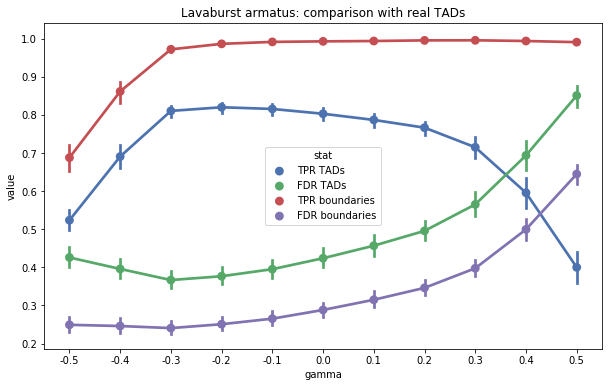

In [70]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_armatus_stats, x="gamma", y="value", hue="stat")
plt.title("Lavaburst armatus: comparison with real TADs")
plt.savefig("lava_stats_all.png")

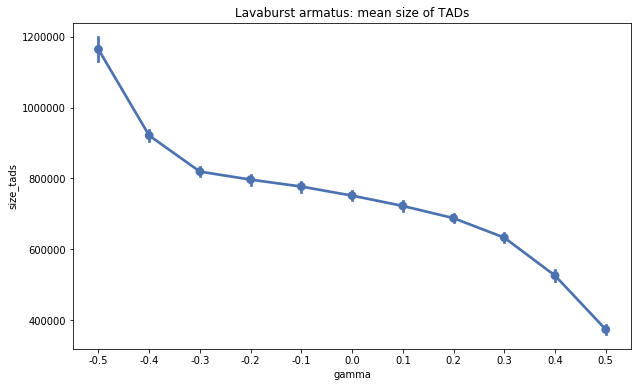

In [38]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_armatus_stats, x="gamma", y="size_tads")
plt.title("Lavaburst armatus: mean size of TADs")
plt.savefig("lava_size_TADs_all_mean.png")

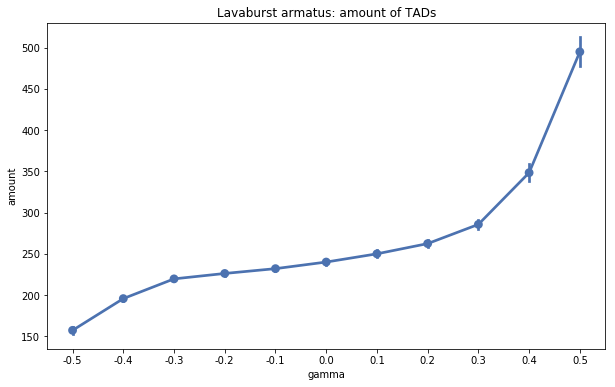

In [72]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_armatus_stats, x="gamma", y="amount")
plt.title("Lavaburst armatus: amount of TADs")
plt.savefig("lava_amount_TADs_all.png")

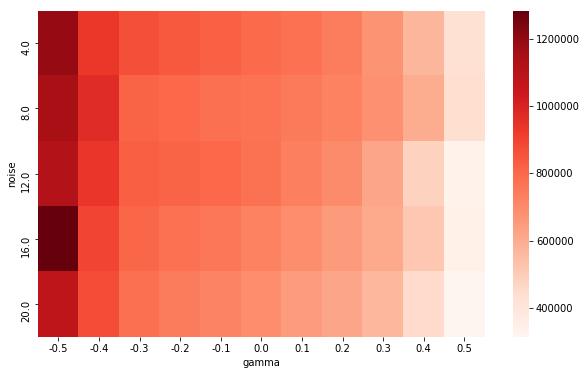

In [40]:
lava_armatus_stats["amount"] = np.array(lava_armatus_stats["amount"], dtype=int)
lava_armatus_stats["value"] = np.array(lava_armatus_stats["value"], dtype=float)
lava_armatus_stats["size_tads"] = np.array(lava_armatus_stats["size_tads"], dtype=float)
armatus_sizes = lava_armatus_stats[lava_armatus_stats.stat == "TPR TADs"].pivot_table(index=["noise"], columns=["gamma"], values="size_tads", aggfunc=np.mean)
sns.heatmap(armatus_sizes, cmap="Reds")

In [73]:
df = pd.DataFrame(index=range(len(noise_values) * len(sim_values) * len(armatus_gamma) * len(stats)), columns=["X", "Y", "Z"])
df.loc[:, "X"] = lava_armatus_stats["gamma"]
df.loc[:, "Y"] = lava_armatus_stats["noise"]
df.loc[:, "Z"] = lava_armatus_stats["size_tads"]

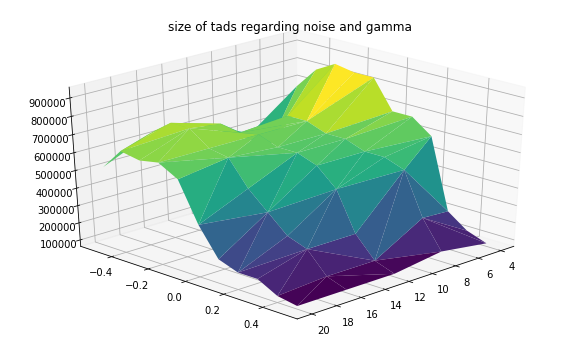

In [78]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df["Y"], df["X"], df["Z"], cmap=plt.cm.viridis, linewidth=0.2)
plt.title("size of tads regarding noise and gamma")
ax.view_init(30, 45)
plt.show()

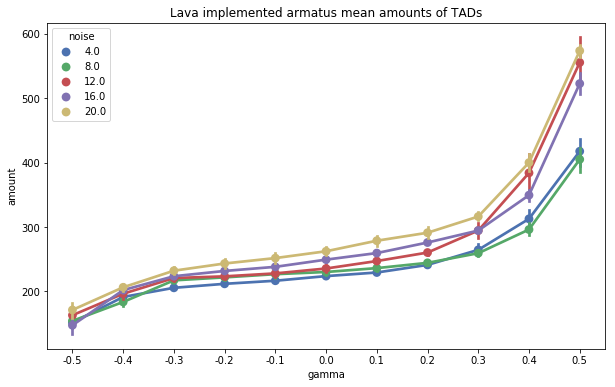

In [41]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_armatus_stats, x="gamma", y="amount", hue="noise")
plt.title("Lava implemented armatus mean amounts of TADs")
plt.savefig("lava_armatus_TAD_amount_noise.png")

The best one gamma for armatus in lavaburst is -0.3. The best gamma corresponds to the biggest median size of TADs. 

In [92]:
# convert armatus tad coordinates for further handling
armatus_gamma = [i / 10 for i in range(-5, 6)]
for noise in noise_values:
    for sim in sim_values:
        for gamma in armatus_gamma:
            tads = pd.read_csv(f"{out_location}armatus_gamma{gamma}_noise{noise}_sim{sim}.consensus.txt", comment = "#", sep = "\t", header=None)
            del tads[0]
            tads[2] = tads[2] + 1
            tads.to_csv(f"{out_location}armatus_noise{noise}_sim{sim}_gamma{gamma}.txt", sep="\t", header=None, index=False)
    

In [42]:
# armatus standalone stats for all files
armatus_gamma = [i / 10 for i in range(-5, 6)]
armatus_stats = pd.DataFrame(index=range(len(noise_values) * len(sim_values) * len(armatus_gamma) * len(stats)), columns=list(("value", "stat", "noise", "sim", "gamma", "amount", "size_tads")))
item = 0
for noise in noise_values:
    for sim in sim_values:
        for gamma in armatus_gamma:
                print(f"\r method=armatus noise={noise} sim={sim} gamma={gamma}", end="")
                TADs = np.loadtxt(f"{out_location}armatus_noise{noise}_sim{sim}_gamma{gamma}.txt", ndmin=2)
                sizes = np.mean(TADs[:, 1] - TADs[:, 0])
                bins = TAD_bins(TADs[:, 0], TADs[:, 1])
                boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
                armatus_stats.loc[item, "value"] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
                armatus_stats.loc[item, "stat":"amount"] = ["TPR TADs", noise, sim, gamma, TADs.shape[0]]
                armatus_stats.loc[item, "size_tads"] = sizes
                item += 1
                armatus_stats.loc[item, "value"] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
                armatus_stats.loc[item, "stat":"amount"] = ["FDR TADs", noise, sim, gamma, TADs.shape[0]]
                armatus_stats.loc[item, "size_tads"] = sizes
                item += 1
                armatus_stats.loc[item, "value"] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
                armatus_stats.loc[item, "stat":"amount"] = ["TPR boundaries", noise, sim, gamma, TADs.shape[0]]
                armatus_stats.loc[item, "size_tads"] = sizes
                item += 1
                armatus_stats.loc[item, "value"] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]
                armatus_stats.loc[item, "stat":"amount"] = ["FDR boundaries", noise, sim, gamma, TADs.shape[0]]
                armatus_stats.loc[item, "size_tads"] = sizes
                item += 1

 method=armatus noise=20 sim=5 gamma=0.51

In [43]:
armatus_stats["gamma"] = np.array(armatus_stats["gamma"], dtype=float)
armatus_stats["noise"] = np.array(armatus_stats["noise"], dtype=float)
armatus_stats["size_tads"] = np.array(armatus_stats["size_tads"], dtype=float)

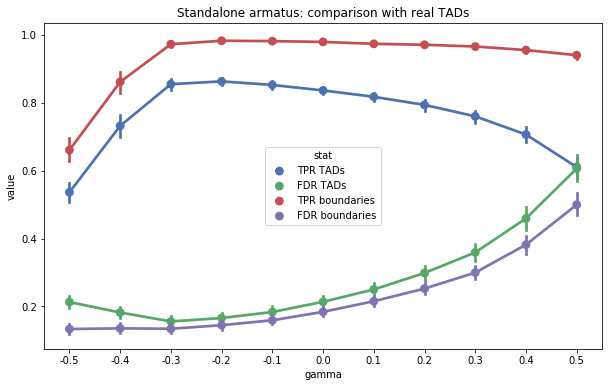

In [44]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=armatus_stats, x="gamma", y="value", hue="stat")
plt.title("Standalone armatus: comparison with real TADs")
plt.savefig("armatus_stats_all_mean.png")

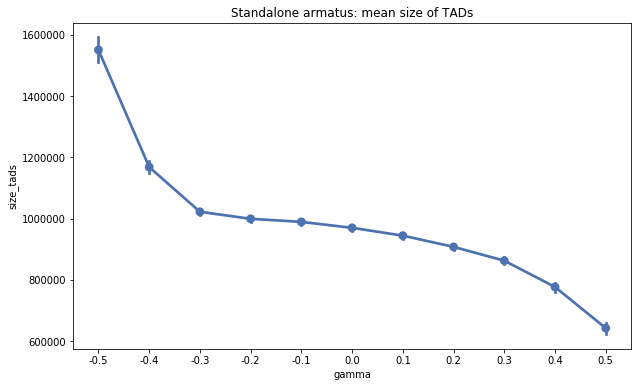

In [45]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=armatus_stats, x="gamma", y="size_tads")
plt.title("Standalone armatus: mean size of TADs")
plt.savefig("armatus_size_TADs_all_mean.png")

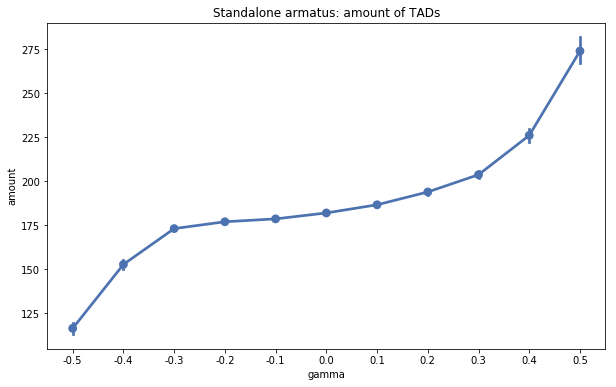

In [83]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=armatus_stats, x="gamma", y="amount")
plt.title("Standalone armatus: amount of TADs")
plt.savefig("armatus_amount_TADs_all.png")

In [25]:
armatus_gamma = [i / 10 for i in range(-5, 6)]
compare_stats = ["JI TADs", "JI boundaries", "OC TADs", "OC boundaries"]
compare_armatus = pd.DataFrame(index=range(len(armatus_gamma) * len(noise_values) * len(sim_values) * len(compare_stats)), columns = ["noise", "sim", "gamma", "value", "stat"])
index = 0
for noise in noise_values:
    for sim in sim_values:
        for gamma in armatus_gamma:
            print(f"\rnoise={noise} sim={sim} gamma={gamma}", end="")
            lava_TADs = np.loadtxt(f"{out_location}lava_armatus_noise{noise}_sim{sim}_gamma{gamma}.txt", ndmin=2)
            lava_bins = TAD_bins(lava_TADs[:, 0], lava_TADs[:, 1])
            lava_boundaries = TAD_boundaries(lava_TADs[:, 0], lava_TADs[:, 1])
            original_TADs = np.loadtxt(f"{out_location}armatus_noise{noise}_sim{sim}_gamma{gamma}.txt", ndmin=2)
            original_bins = TAD_bins(original_TADs[:, 0], original_TADs[:, 1])
            original_boundaries = TAD_boundaries(original_TADs[:, 0], original_TADs[:, 1])
            compare_armatus.loc[index, :] = [noise, sim, gamma, jaccard_index(lava_bins, original_bins), "JI TADs"]
            index += 1
            compare_armatus.loc[index, :] = [noise, sim, gamma, jaccard_index(lava_boundaries, original_boundaries), "JI boundaries"]
            index += 1
            compare_armatus.loc[index, :] = [noise, sim, gamma, overlap_coef(lava_bins, original_bins), "OC TADs"]
            index += 1
            compare_armatus.loc[index, :] = [noise, sim, gamma, overlap_coef(lava_boundaries, original_boundaries), "OC boundaries"]
            index += 1

noise=20 sim=5 gamma=0.51

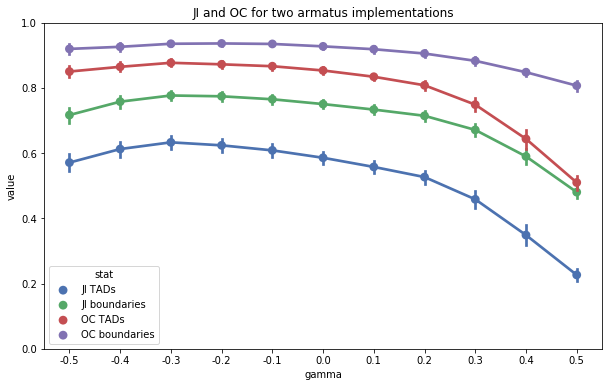

In [26]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=compare_armatus, x="gamma", y="value", hue="stat")
plt.title("JI and OC for two armatus implementations")
plt.ylim(0,1)
plt.savefig("compare_armatuses.png")

In [46]:
# hicseg stats
hicseg_stats = pd.DataFrame(index=range(len(noise_values) * len(sim_values) * len(stats)), columns=list(("value", "stat", "noise", "sim", "amount", "size_tads")))
item = 0
for noise in noise_values:
    for sim in sim_values:
            print(f"\r method=hicseg noise={noise} sim={sim} gamma={gamma}", end="")
            TADs = np.loadtxt(f"{out_location}hicseg_noise{noise}_sim{sim}.txt", ndmin=2)
            sizes = np.mean(TADs[:, 1] - TADs[:, 0])
            bins = TAD_bins(TADs[:, 0], TADs[:, 1])
            boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
            hicseg_stats.loc[item, "value"] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
            hicseg_stats.loc[item, "stat":"amount"] = ["TPR TADs", noise, sim, TADs.shape[0]]
            hicseg_stats.loc[item, "size_tads"] = sizes
            item += 1
            hicseg_stats.loc[item, "value"] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
            hicseg_stats.loc[item, "stat":"amount"] = ["FDR TADs", noise, sim, TADs.shape[0]]
            hicseg_stats.loc[item, "size_tads"] = sizes
            item += 1
            hicseg_stats.loc[item, "value"] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
            hicseg_stats.loc[item, "stat":"amount"] = ["TPR boundaries", noise, sim, TADs.shape[0]]
            hicseg_stats.loc[item, "size_tads"] = sizes
            item += 1
            hicseg_stats.loc[item, "value"] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]
            hicseg_stats.loc[item, "stat":"amount"] = ["FDR boundaries", noise, sim, TADs.shape[0]]
            hicseg_stats.loc[item, "size_tads"] = sizes
            item += 1

 method=hicseg noise=20 sim=5 gamma=0.5

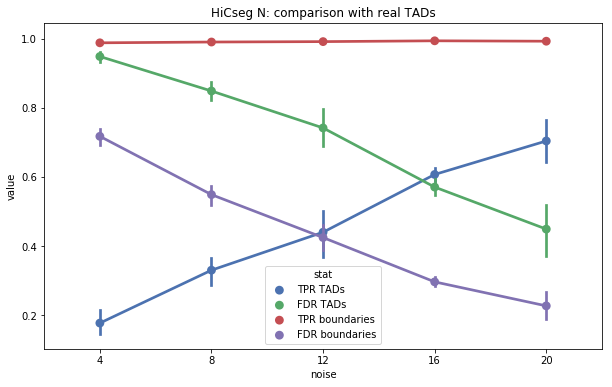

In [47]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=hicseg_stats, x="noise", y="value", hue="stat")
plt.title("HiCseg N: comparison with real TADs")
plt.savefig("hicseg_stats.png")

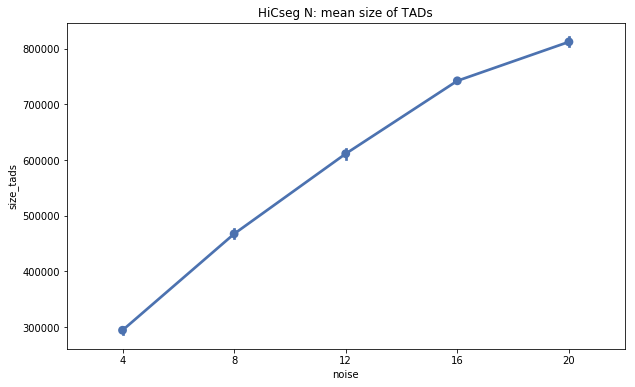

In [48]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=hicseg_stats, x="noise", y="size_tads")
plt.title("HiCseg N: mean size of TADs")
plt.savefig("hicseg_size_tads_mean.png")

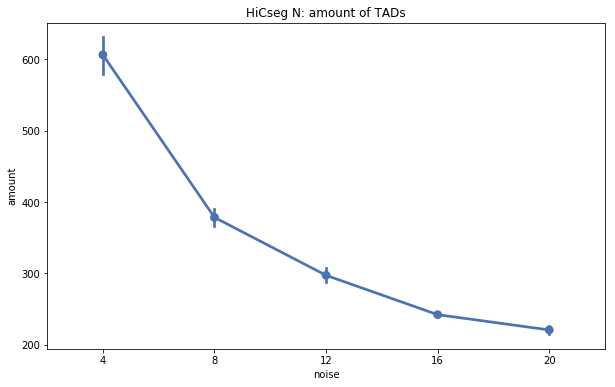

In [145]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=hicseg_stats, x="noise", y="amount")
plt.title("HiCseg N: amount of TADs")
plt.savefig("hicseg_amount_tads.png")

In [49]:
# hicseg stats
hicseg_pois_stats = pd.DataFrame(index=range(len(noise_values) * len(sim_values) * len(stats)), columns=list(("value", "stat", "noise", "sim", "amount", "size_tads")))
item = 0
for noise in noise_values:
    for sim in sim_values:
            print(f"\r method=hicseg noise={noise} sim={sim} gamma={gamma}", end="")
            TADs = np.loadtxt(f"{out_location}hicseg_P_noise{noise}_sim{sim}.txt", ndmin=2)
            sizes = np.mean(TADs[:, 1] - TADs[:, 0])
            bins = TAD_bins(TADs[:, 0], TADs[:, 1])
            boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
            hicseg_pois_stats.loc[item, "value"] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
            hicseg_pois_stats.loc[item, "stat":"amount"] = ["TPR TADs", noise, sim, TADs.shape[0]]
            hicseg_pois_stats.loc[item, "size_tads"] = sizes
            item += 1
            hicseg_pois_stats.loc[item, "value"] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
            hicseg_pois_stats.loc[item, "stat":"amount"] = ["FDR TADs", noise, sim, TADs.shape[0]]
            hicseg_pois_stats.loc[item, "size_tads"] = sizes
            item += 1
            hicseg_pois_stats.loc[item, "value"] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
            hicseg_pois_stats.loc[item, "stat":"amount"] = ["TPR boundaries", noise, sim, TADs.shape[0]]
            hicseg_pois_stats.loc[item, "size_tads"] = sizes
            item += 1
            hicseg_pois_stats.loc[item, "value"] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]
            hicseg_pois_stats.loc[item, "stat":"amount"] = ["FDR boundaries", noise, sim, TADs.shape[0]]
            hicseg_pois_stats.loc[item, "size_tads"] = sizes
            item += 1

 method=hicseg noise=20 sim=5 gamma=0.5

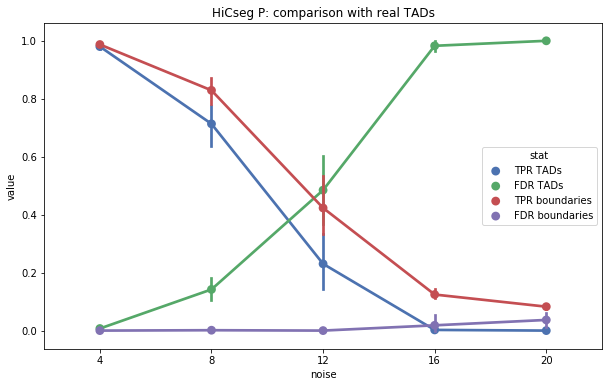

In [141]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=hicseg_pois_stats, x="noise", y="value", hue="stat")
plt.title("HiCseg P: comparison with real TADs")
plt.savefig("hicseg_P_stats.png")

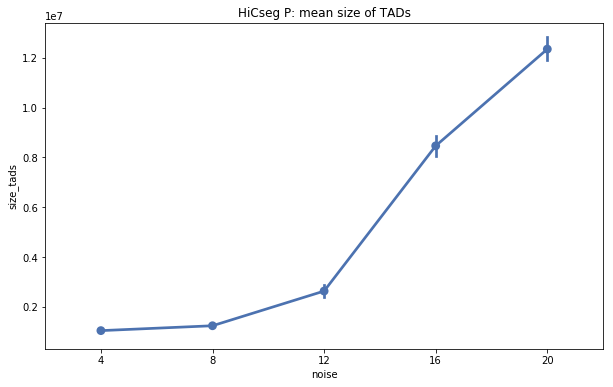

In [50]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=hicseg_pois_stats, x="noise", y="size_tads")
plt.title("HiCseg P: mean size of TADs")
plt.savefig("hicseg_P_size_tads_mean.png")

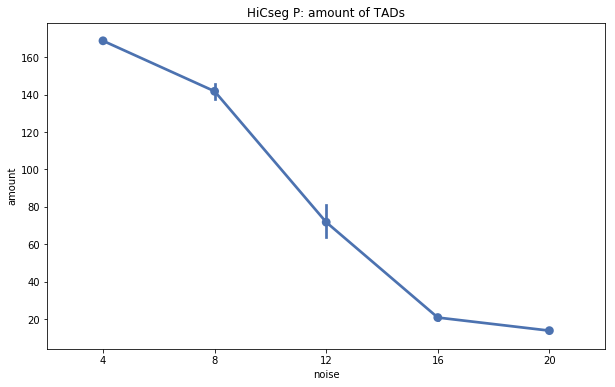

In [148]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=hicseg_pois_stats, x="noise", y="amount")
plt.title("HiCseg P: amount of TADs")
plt.savefig("hicseg_P_amount_tads.png")

In [51]:
ideal_gamma = {"armatus": -0.3, "lava_armatus": -0.3, "lava_variance": 6, "lava_potts": 16, "lava_corner": 2, "lava_modularity":16}
ideal_params = {"ii": (7, 160000.0), "di": (13, 160000)}
method_name = {"armatus":"Armatus\nstandalone", "lava_armatus":"Armatus\nlavaburst", "lava_variance":"Variance", "lava_potts":"Potts", "lava_corner":"Corner", "lava_modularity":"Modularity", "ii":"Insulation\nscore", "di":"Directionality\nindex", "hicseg":"HiCseg N", "hicseg_P":"HiCseg P"}

In [52]:
ideal_stats = pd.DataFrame(index=range(((len(ideal_gamma.keys()) + len(ideal_params.keys())) * len(sim_values) * len(noise_values) + 1) * 2), columns=["method", "sim", "Noise", "value", "stat"])

In [53]:
index = 0
for method in ideal_gamma.keys():
    for sim in sim_values:
        for noise in noise_values:
            if method == "lava_variance" and (noise > 4 or sim > 1):
                continue
            print(f"\r method=method noise={noise} sim={sim} gamma={ideal_gamma[method]}", end="")
            TADs = np.loadtxt(f"{out_location}{method}_noise{noise}_sim{sim}_gamma{ideal_gamma[method]}.txt", ndmin=2)
            sizes = np.median(TADs[:, 1] - TADs[:, 0])
            ideal_stats.loc[index, :] = [method_name[method], sim, noise, TADs.shape[0], "amount"]
            index += 1
            ideal_stats.loc[index, :] = [method_name[method], sim, noise, sizes, "tad_sizes"]
            index += 1
for method in ideal_params.keys():
    for sim in sim_values:
        for noise in noise_values:
            print(f"\r method=method noise={noise} sim={sim}", end="")
            TADs = np.loadtxt(f"{out_location}{method}_noise{noise}_sim{sim}_window{ideal_params[method][1]}_cutoff{ideal_params[method][0]}.txt", ndmin=2)
            if TADs.shape[0] == 0:
                ideal_stats.loc[index, :] = [method_name[method], sim, noise, 0, "amount"]
                index += 1
                ideal_stats.loc[index, :] = [method_name[method], sim, noise, 0, "tad_sizes"]
                index += 1
                continue
            sizes = np.median(TADs[:, 1] - TADs[:, 0])
            ideal_stats.loc[index, :] = [method_name[method], sim, noise, TADs.shape[0], "amount"]
            index += 1
            ideal_stats.loc[index, :] = [method_name[method], sim, noise, sizes, "tad_sizes"]
            index += 1
for method in ["hicseg", "hicseg_P"]:
    for sim in sim_values:
        for noise in noise_values:
            print(f"\r method=method noise={noise} sim={sim}", end="")
            TADs = np.loadtxt(f"{out_location}{method}_noise{noise}_sim{sim}.txt", ndmin=2)
            sizes = np.median(TADs[:, 1] - TADs[:, 0])
            ideal_stats.loc[index, :] = [method_name[method], sim, noise, TADs.shape[0], "amount"]
            index += 1
            ideal_stats.loc[index, :] = [method_name[method], sim, noise, sizes, "tad_sizes"]
            index += 1
            

 method=method noise=20 sim=4 gamma=16.3

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: loadtxt: Empty input file: "yielded/ii_noise20_sim3_window160000.0_cutoff7.txt"


 method=method noise=20 sim=5

In [54]:
ideal_stats["value"] = np.array(ideal_stats["value"], dtype=float)

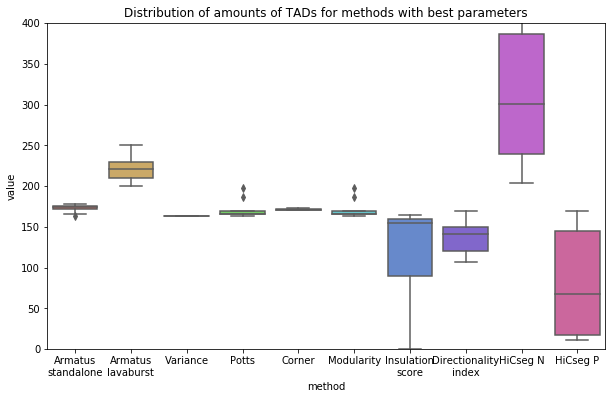

In [162]:
sns.set_palette(sns.color_palette("hls", 10))
sns.boxplot(data=ideal_stats[ideal_stats.stat == "amount"], x="method", y="value")
plt.title("Distribution of amounts of TADs for methods with best parameters")
plt.ylim(0, 400)
plt.savefig("amounts_best_all.png")

In [1]:
sns.set_palette(sns.color_palette("hls", 10))
sns.boxplot(data=ideal_stats[ideal_stats.stat == "tad_sizes"], x="method", y="value")
plt.title("Distribution of mean sizes of TADs for methods with best parameters")
plt.ylim(0, 2000000)
plt.savefig("sizes_best_all.png")

NameError: name 'sns' is not defined

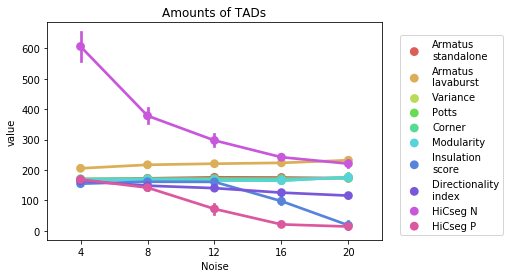

In [21]:
sns.set_palette(sns.color_palette("hls", 10))
sns.pointplot(data=ideal_stats[ideal_stats.stat == "amount"], x="Noise", y="value", hue="method")
plt.title("Amounts of TADs")
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")
plt.savefig("amount~noise_all.png")

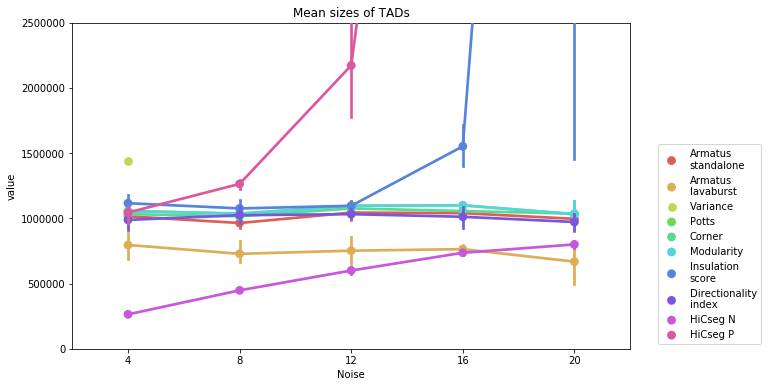

In [56]:
sns.set_palette(sns.color_palette("hls", 10))
sns.pointplot(data=ideal_stats[ideal_stats.stat == "tad_sizes"], x="Noise", y="value", hue="method")
plt.ylim(0, 2500000)
plt.title("Mean sizes of TADs")
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")
plt.savefig("size~noise_all_mean.png")

In [169]:
ideal_stats_2 = pd.DataFrame(index=range((len(method_name.keys()) * len(sim_values) * len(noise_values) + 1) * 4), columns=["method", "sim", "Noise", "value", "stat"])

In [170]:
methods_1param = {"lava_armatus": lava_armatus_stats, "armatus": armatus_stats, "lava_corner": lava_corner_stats, "lava_variance": lava_variance_stats, "lava_potts": lava_potts_stats, "lava_modularity":lava_modularity_stats}
methods_2param = {"ii": ii_stats, "di":di_stats}
methods_0param = {"hicseg":hicseg_stats, "hicseg_P":hicseg_pois_stats}

In [171]:
start = 0
for method in ideal_gamma.keys():
    print(f"\r{method}" + " " * 100, end="")
    ideal_param_mask = methods_1param[method]["gamma"] == ideal_gamma[method]
    ideal_values = np.array(methods_1param[method][ideal_param_mask].loc[:, ["sim", "noise", "value", "stat"]], dtype=object)
    ideal_stats_2.loc[start:ideal_values.shape[0] - 1 + start, "sim":"stat"] = ideal_values
    ideal_stats_2.loc[start:ideal_values.shape[0] - 1 + start, "method"] = method_name[method]
    start += ideal_values.shape[0]
for method in ideal_params.keys():
    print(f"\r{method}" + " " * 100, end="")
    ideal_param_mask = (methods_2param[method]["cutoff"] == ideal_params[method][0]) & (methods_2param[method]["window"] == ideal_params[method][1])
    ideal_values = np.array(methods_2param[method][ideal_param_mask].loc[:, ["sim", "noise", "value", "stat"]], dtype=object)
    ideal_stats_2.loc[start:ideal_values.shape[0] - 1 + start, "sim":"stat"] = ideal_values
    ideal_stats_2.loc[start:ideal_values.shape[0] - 1 + start, "method"] = method_name[method]
    start += ideal_values.shape[0]
for method in ["hicseg", "hicseg_P"]:
    print(f"\r{method}" + " " * 100, end="")
    ideal_values = np.array(methods_0param[method].loc[:, ["sim", "noise", "value", "stat"]], dtype=object)
    ideal_stats_2.loc[start:ideal_values.shape[0] - 1 + start, "sim":"stat"] = ideal_values
    ideal_stats_2.loc[start:ideal_values.shape[0] - 1 + start, "method"] = method_name[method]
    start += ideal_values.shape[0]

hicseg_P                                                                                                    

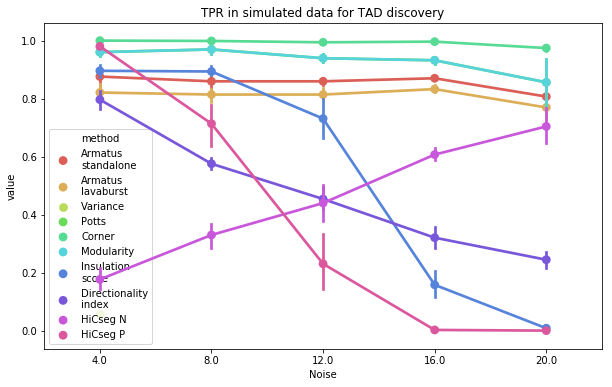

In [172]:
sns.set_palette(sns.color_palette("hls", 10))
sns.pointplot(data=ideal_stats_2[ideal_stats_2["stat"] == "TPR TADs"], x="Noise", y="value", hue="method")
plt.title("TPR in simulated data for TAD discovery")
plt.savefig("TPR_TADs~noise_all.png")

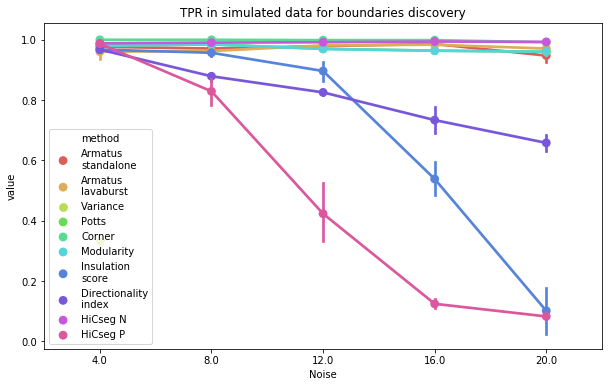

In [174]:
sns.set_palette(sns.color_palette("hls", 10))
sns.pointplot(data=ideal_stats_2[ideal_stats_2["stat"] == "TPR boundaries"], x="Noise", y="value", hue="method")
plt.title("TPR in simulated data for boundaries discovery")
plt.savefig("TPR_boundaries~noise_all.png")

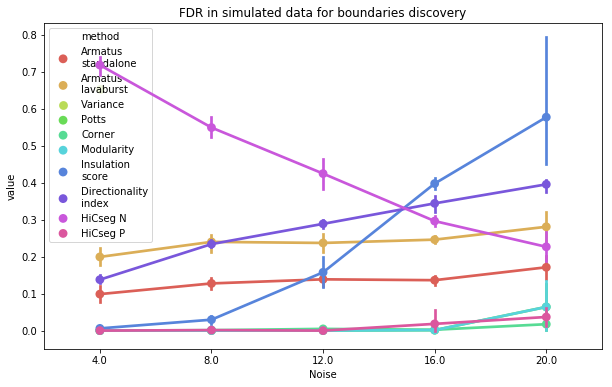

In [175]:
sns.set_palette(sns.color_palette("hls", 10))
sns.pointplot(data=ideal_stats_2[ideal_stats_2["stat"] == "FDR boundaries"], x="Noise", y="value", hue="method")
plt.title("FDR in simulated data for boundaries discovery")
plt.savefig("FDR_boundaries~noise_all.png")

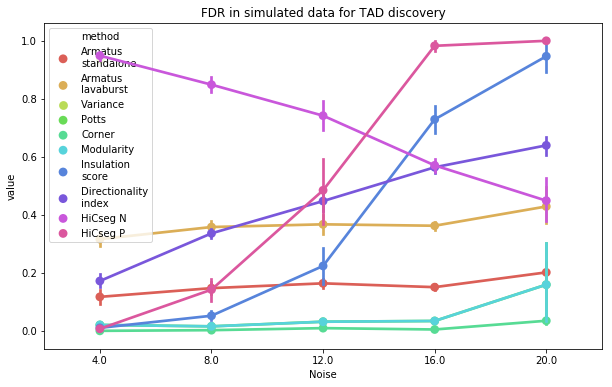

In [177]:
sns.set_palette(sns.color_palette("hls", 10))
sns.pointplot(data=ideal_stats_2[ideal_stats_2["stat"] == "FDR TADs"], x="Noise", y="value", hue="method")
plt.title("FDR in simulated data for TAD discovery")
plt.savefig("FDR_TADs~noise_all.png")